In [1]:
import tensorflow as tf
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import seaborn as sb
import os,re
from string import punctuation
import random
from tqdm import tqdm
import pickle
import pandas as pd
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split


def reset_random_seeds():
    os.environ['PYTHONHASHSEED']=str(2)
    tf.random.set_seed(2)
    np.random.seed(2)
    
    random.seed(2)
    
tf.config.list_physical_devices('GPU')

2024-10-19 21:20:42.151368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-19 21:20:42.172178: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-19 21:20:42.178326: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-19 21:20:42.193272: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-19 21:20:43.243088: W tensorflow/compiler/tf2

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
def preprocess_text(x,tweet=False):
    """
    cleaning tweets -> 
    @user -> USER
    urls -> LINK
    keep only !,.:#? and add space 
    """
    x = str(x).replace('&amp;','and').replace('<br />','').replace('&quot;','').lower()
    x = re.sub(r'&#x[0-9A-Fa-f]+;','',x)
    x = re.sub(r'&#\d+;',"'",x)
    x = re.sub(r'[^\x00-\x7F]+', "'",x)
    
    url_pattern = r'http\S+|www\S+'
    x = re.sub(url_pattern, 'LINK', x).split()
    for i,w in enumerate(x):
        if '@' in w:
            x[i] = 'USER'
    x = ' '.join(x)
    punct_to_keep = """!,.:#?"-;//%$'"""
    punct = ''.join([p for p in punctuation if p not in punct_to_keep])
    trans = str.maketrans(punct, ' ' * len(punct))
    x = x.translate(trans)
    x = ''.join(x)
    x = re.sub(r'([!"#$%&\()*+,-./:;<=>?@\\^_`{|}~])\s*\1+', r'\1', x)
    x = re.sub(r'([!"#$%&\()*+,-./:;<=>?@\\^_`{|}~])', r' \1 ', x)
    x = re.sub(r'\s+', ' ', x).strip().replace("'s "," 's ")
    x = x.replace("\\'"," '").replace("'"," ' ")
    x = x + ' '
#     x = x.replace(" ' s "," 's ")
    return re.sub(r'\s+', ' ', x).strip().replace("\\'s","'s")


In [1]:
# preprocess text

df = pd.read_csv('IMDB Dataset.csv')
df['cleaned_text'] = df.text.apply(lambda x: preprocess_text(x))
df.sentiment = df.sentiment.map({'negative':0,'positive':1})

NameError: name 'pd' is not defined

In [ ]:
# load trained wordpiece tokenizer

from custom_tokenizer import WordPieceTokenizer

if __name__ == "__main__":

    with open('wp_tok_en.pkl','rb') as f:
        wp_tok = pickle.load(f)

# set tokenizer maxlen to 128

wp_tok.maxlen = 128

In [15]:
# get padded tokenized sequences

seqs = [wp_tok.tokenize(x) for x in df.cleaned_text]
seqs = [wp_tok.add_padding(x) for x in seqs]
seqs = np.array(seqs,dtype=np.int16)

In [18]:
# split training and testing data

xtrain,xtest,ytrain,ytest = train_test_split(seqs,df.sentiment,
                                             train_size=0.8,random_state=0)

In [19]:
# input sample as text

' '.join([wp_tok.i2w[t] for t in xtrain[10] if t>0])

"<cls> add pure humor quick and unique sentences sex unf ##a ##it ##h sex ! love lies dark deadly thoughts secret plans fun black humor sex ! . again ! black dresses ! needed for the unlimited funeral ##s ! eg ##li ##ma ##ta ! or in english , crimes ! our heroes are two married couples , their relatives , their friends and neighbors . there is so ##s ##o and al ##e ##ko ##s and flora and ac ##h ##i ##ll ##e ##as , two married couples who have everything but not real love ! flora is the mistress of al ##e ##ko ##s , and when so ##s ##o finds what ' s going on , she is planning with her best friend pe <sep>"

In [27]:
from Bert.bert import BERT


# load mlm pretrained
bert_layer = tf.keras.models.load_model('Bert/BERT_pretrainded.keras',custom_objects={'BERT':BERT}).layers[1]
bert_layer.embedding.pos_emb_layer.trainable = False



reset_random_seeds()

batch = 16

# build model for text classification

i = tf.keras.layers.Input((wp_tok.maxlen,),dtype=tf.int16,batch_size=batch)
x = bert_layer(i)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
out = tf.keras.layers.Dense(1,activation='sigmoid')(x)

bert_model = tf.keras.Model(i,out)
bert_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (16, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bert (BERT)                     │ (16, 128, 256)         │     4,538,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (16, 256)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (16, 1)                │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,538,369 (17.31 MB)

 Trainable params: 4,505,601 (17.19 MB)

 Non-trainable params: 32,768 (128.00 KB)

In [28]:
@tf.function
def train_step(x,y,model):
    with tf.GradientTape() as tape:
        pred = model(x,training=True)
        loss = loss_fn(y,pred)
    weights = model.trainable_weights
    grads = tape.gradient(loss,weights)
    opt.apply_gradients(zip(grads,weights))
    return loss


@tf.function
def test_step(x,y,model):
    pred = model(x,training=False)
    loss = loss_fn(y,pred)
    return loss

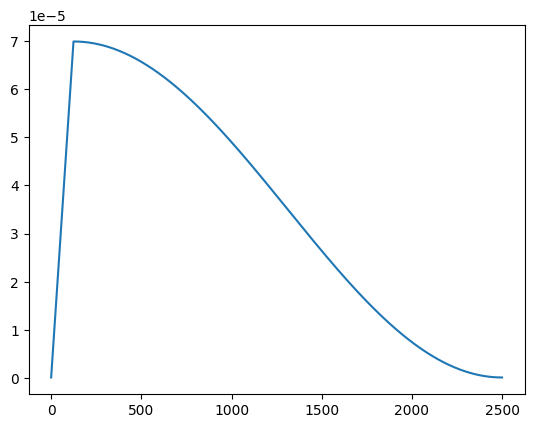

In [29]:
# initalize loss function optimizer and LR Scheduler

loss_fn = tf.keras.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.AdamW(weight_decay=0.01)


class CosineLRScheduler:
    def __init__(self,total_steps,max_lr=7e-5,min_lr=1e-8,init_lr=1e-8):
        self.max_lr = max_lr
        self.min_lr = min_lr
        self.init_lr = init_lr
        self.total_setps = total_steps
        self.warmup = int(total_steps * 0.05)
        self.decay = total_steps - self.warmup
        self.warmup_lr = np.linspace(init_lr,max_lr,self.warmup)
        
        
    def __call__(self,step):
        
        if step <= self.warmup:
            
            lr = self.warmup_lr[step-1]
        else:   
            step = step - self.warmup
            lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(step * np.pi / self.decay))
        
        return lr



total_steps = len(xtrain) // batch + 1
    

train = tf.data.Dataset.from_tensor_slices((xtrain,ytrain))
train = train.batch(batch_size=batch).shuffle(buffer_size=100)

valid = tf.data.Dataset.from_tensor_slices((xtest,ytest)).batch(batch_size=batch)


# lr_decay = [cosine_lr_decay(s,total_setps=total_steps,max_lr=3e-4,min_lr=0) for s in range(1,total_steps+1)]

lr_scheduler = CosineLRScheduler(total_steps)

# lr_scheduler(152)
plt.plot([lr_scheduler(i) for i in range(1,total_steps+1)])


In [30]:
# train model for text classification

epochs = 3

losses = {'train':[],'valid':[]}
check = []
for e in range(1,epochs+1):
    
    print(f'EPOCH : {e}/{epochs}')
    
    loss = 0
    for i,(x,y) in enumerate(tqdm(train)):
        lr = lr_scheduler(i+1)
        opt.learning_rate.assign(lr)
        loss += train_step(x,y,bert_model)
        
    train_loss = np.round((loss / (i+1)).numpy(),4)
    
    losses['train'].append(train_loss)
    
    loss = 0
    for i,(x,y) in enumerate(valid):
        loss += test_step(x,y,bert_model)
        
    
    loss = np.round((loss / (i+1)).numpy(),4) 
    
    print('train_loss :',train_loss)
    print('val_loss :',loss)
    
    if e == 1:
        bert_model.save_weights(f'Bert/bert_weights.weights.h5')
        print('weights saved')
        
    elif e > 1 and min(losses['valid']) > loss:
        bert_model.save_weights(f'Bert/bert_weights.weights.h5')
        print('weights saved')
    
    losses['valid'].append(loss)
    print()

EPOCH : 1/3


100%|███████████████████████████████████████| 2500/2500 [00:40<00:00, 61.73it/s]
2024-10-19 09:23:36.928070: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


train_loss : 0.4621
val_loss : 0.4017
weights saved

EPOCH : 2/3


100%|███████████████████████████████████████| 2500/2500 [00:35<00:00, 71.04it/s]


train_loss : 0.3659
val_loss : 0.37
weights saved

EPOCH : 3/3


100%|███████████████████████████████████████| 2500/2500 [00:35<00:00, 70.64it/s]


train_loss : 0.3196
val_loss : 0.358
weights saved



In [31]:
# load best weights

bert_model.load_weights('bert_weights.weights.h5')

In [32]:
# get predictions

preds = []
for i,(x,y) in enumerate(valid):
    
    p = np.round(bert_model(x).numpy()[:,0])
    preds.extend(p)

In [33]:
# get metrics

print(classification_report(ytest,preds))
f1_score(ytest.values,preds)

              precision    recall  f1-score   support

           0       0.85      0.84      0.84      5035
           1       0.84      0.85      0.84      4965

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



0.8433253397282174

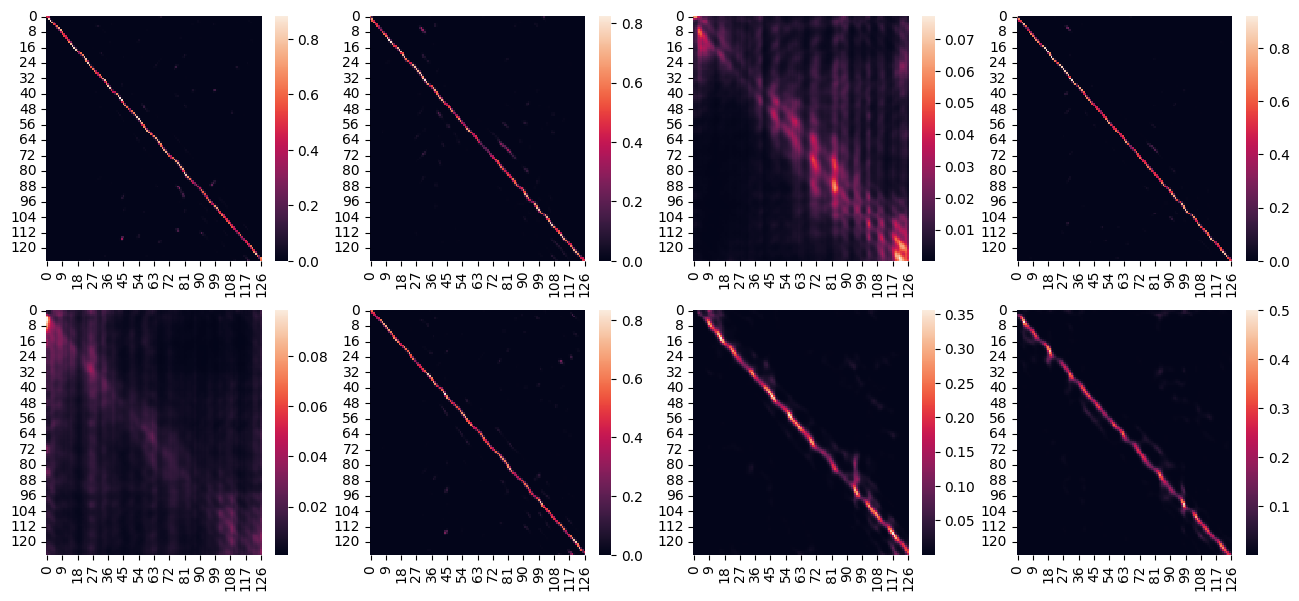

In [28]:
# visualize attention plots for both layers

i = np.random.randint(0,len(xtest)-1)
x = xtest[i][:,np.newaxis]
bert_model(x)

idx = np.where(x!=0)[0][-1]

attn_scores = bert_model.layers[1].encoder_layers[-1].attention.attention_scores.numpy()[0,:,:idx,:idx]

_,ax = plt.subplots(2,4,figsize=(16,7))

for i in range(2):
    for j in range(4):
        sb.heatmap(np.reshape(attn_scores,(2,4,idx,idx))[i][j],ax=ax[i][j])
        
plt.show()



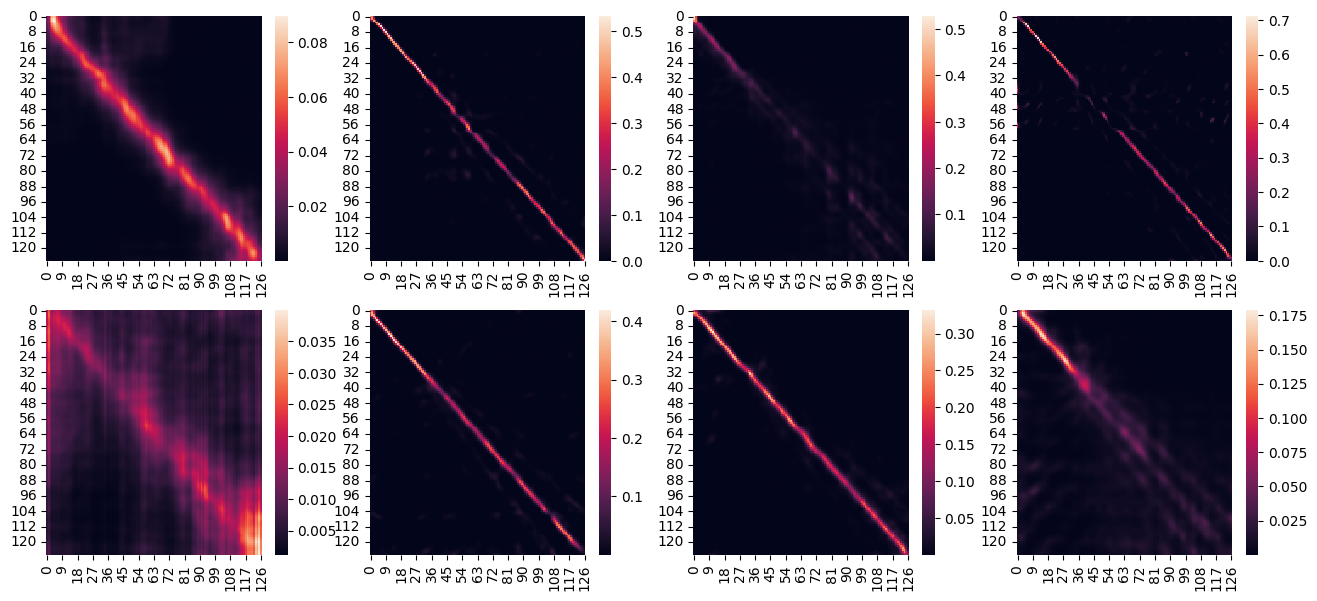

In [29]:
attn_scores = bert_model.layers[1].encoder_layers[0].attention.attention_scores.numpy()[0,:,:idx,:idx]

_,ax = plt.subplots(2,4,figsize=(16,7))

for i in range(2):
    for j in range(4):
        sb.heatmap(np.reshape(attn_scores,(2,4,idx,idx))[i][j],ax=ax[i][j])
        
plt.show()